In [1]:
# Install necessary libraries
!pip install pandas numpy scikit-learn xgboost lightgbm catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 3.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" an

In [2]:
# Import libraries
import os
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
import pickle

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## **Load Data**

In [3]:
# Load Data
path = "/content/sample_data/data"
all_files = os.listdir(path)

In [4]:
train_delay = pd.DataFrame()
for file in all_files:
    df = pd.read_csv(os.path.join(path, file))
    train_delay = pd.concat([train_delay, df])
train_delay = train_delay.reset_index(drop=True)

In [5]:
train_delay

,rid,tpl,pta,ptd,wta,wtp,wtd,arr_et,arr_wet,arr_atRemoved,...,pass_wet,pass_atRemoved,dep_et,dep_wet,dep_atRemoved,arr_at,pass_at,dep_at,cr_code,lr_code
0,201803017101237,NRCH,NaN,05:00,NaN,NaN,05:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05:00,NaN,NaN
1,201803017101237,NRCHTPJ,NaN,NaN,NaN,05:01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201803017101237,TRWSSBJ,NaN,NaN,NaN,05:01:30,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201803017101237,TROWSEJ,NaN,NaN,NaN,05:02:30,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,05:02,NaN,NaN,NaN
4,201803017101237,DISS,05:17,NaN,05:16:30,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,05:19,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494223,201802287621179,FRSTGTJ,NaN,NaN,NaN,22:06:30,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,23:19,NaN,NaN,175.0
494224,201802287621179,STFD,NaN,NaN,NaN,22:08,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,23:24,NaN,NaN,175.0
494225,201802287621179,BOWJ,NaN,NaN,NaN,22:11,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,23:25,NaN,NaN,175.0
494226,201802287621179,BTHNLGR,NaN,NaN,NaN,22:13,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,23:30,NaN,NaN,175.0


In [6]:
train_delay.columns

Index(['rid', 'tpl', 'pta', 'ptd', 'wta', 'wtp', 'wtd', 'arr_et', 'arr_wet',
       'arr_atRemoved', 'pass_et', 'pass_wet', 'pass_atRemoved', 'dep_et',
       'dep_wet', 'dep_atRemoved', 'arr_at', 'pass_at', 'dep_at', 'cr_code',
       'lr_code'],
      dtype='object')

## **Data Preprocessing**

In [7]:
# Data Preprocessing
train_delay.describe()

,rid,arr_atRemoved,pass_wet,pass_atRemoved,dep_atRemoved,cr_code,lr_code
count,4.942280e+05,0.0,0.0,0.0,0.0,10155.000000,50191.000000
mean,2.017432e+14,NaN,NaN,NaN,NaN,143.284589,144.077046
std,4.729337e+10,NaN,NaN,NaN,NaN,27.460505,25.587344
min,2.017010e+14,NaN,NaN,NaN,NaN,100.000000,100.000000
25%,2.017061e+14,NaN,NaN,NaN,NaN,120.000000,120.000000
50%,2.017102e+14,NaN,NaN,NaN,NaN,138.000000,140.000000
75%,2.018032e+14,NaN,NaN,NaN,NaN,169.000000,174.000000
max,2.018073e+14,NaN,NaN,NaN,NaN,186.000000,186.000000


In [8]:
train_delay.isnull().sum()

,0
rid,0
tpl,0
pta,390233
ptd,398437
wta,390227
wtp,120028
wtd,390372
arr_et,493421
arr_wet,493644
arr_atRemoved,494228


In [9]:
print('Number of unique stations in dataset : ', len(train_delay['tpl'].unique()))

Number of unique stations in dataset :  41


In [10]:
# Print the unique station values
unique_stations = train_delay['tpl'].unique()
print('Unique stations in the dataset: ', unique_stations)

Unique stations in the dataset:  ['NRCH' 'NRCHTPJ' 'TRWSSBJ' 'TROWSEJ' 'DISS' 'STWMRKT' 'IPSWICH' 'MANNGTR'
 'CLCHSTR' 'STFD' 'LIVST' 'HAGHLYJ' 'IPSWHJN' 'MRKSTEY' 'IPSWEPJ'
 'IPSWESJ' 'WITHAME' 'CHLMSFD' 'SHENFLD' 'BRTWOOD' 'HRLDWOD' 'GIDEAPK'
 'ROMFORD' 'CHDWLHT' 'GODMAYS' 'SVNKNGS' 'ILFORD' 'MANRPK' 'FRSTGTJ'
 'FRSTGT' 'BOWJ' 'BTHNLGR' 'TROWLKJ' 'GIDEPKJ' 'ILFELEJ' 'SHENFUL'
 'WHELSTJ' 'INGTSTN' 'SHENLEJ' 'MRYLAND' 'NEEDHAM']


In [11]:
# Function to calculate stops from a reference station (e.g., 'NRCH')
sorted_stations =  [
    'NRCH', 'NRCHTPJ', 'TROWSEJ', 'TRWSSBJ', 'DISS', 'STWMRKT', 'NEEDHAM',
    'IPSWICH', 'IPSWESJ', 'IPSWEPJ', 'IPSWHJN', 'MANNGTR', 'CLCHSTR', 'MRKSTEY',
    'WITHAME', 'KELVEDN', 'CHLMSFD', 'SHENFLD', 'BRTWOOD', 'HRLDWOD', 'GIDEAPK',
    'ROMFORD', 'CHDWLHT', 'GODMAYS', 'SVNKNGS', 'ILFORD', 'MANRPK', 'FRSTGT',
    'FRSTGTJ', 'STFD', 'MRYLAND', 'LIVST', 'BTHNLGR', 'BOWJ', 'GIDEPKJ',
    'HAGHLYJ', 'HFLPEVL', 'ILFELEJ', 'INGTSTN', 'INGTSTL', 'SHENFUL', 'SHENLEJ',
    'STWMDGL', 'TROWFLR', 'TROWLKJ', 'WHELSTJ'
]

In [12]:
train_delay.rename(columns={'pta': 'PLANNED_ARRIVAL', 'arr_at': 'ACTUAL_ARRIVAL', 'tpl': 'STATION', 'ptd': 'PLANNED_DEPART'}, inplace=True)
cols = ['rid', 'STATION', 'PLANNED_ARRIVAL', 'ACTUAL_ARRIVAL', "PLANNED_DEPART"]
train_delay = train_delay[cols]

In [13]:
# Dropping missing values
train_delay.dropna(inplace=True)
train_delay = train_delay.reset_index(drop=True)

<ipython-input-13-bbded64a04d1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_delay.dropna(inplace=True)


In [14]:
train_delay = train_delay.reset_index()

In [15]:
train_delay['STATION'].unique()

array(['DISS', 'STWMRKT', 'IPSWICH', 'MANNGTR', 'CLCHSTR', 'CHLMSFD',
       'WITHAME', 'SHENFLD', 'STFD', 'MRKSTEY'], dtype=object)

In [16]:
train_delay.drop(['index'], axis=1, inplace=True)

In [17]:
#Aadding a new column "no of stops in a journey".
def calculate_stops(station, base_index=sorted_stations.index('NRCH')):
    station_index = sorted_stations.index(station)
    return abs(base_index - station_index)

train_delay['stops'] = train_delay['STATION'].apply(calculate_stops)

In [18]:
# Convert times to datetime and calculate train_delay target
train_delay['PLANNED_ARRIVAL'] = pd.to_datetime(train_delay['PLANNED_ARRIVAL'], format='%H:%M', errors='coerce')
train_delay['ACTUAL_ARRIVAL'] = pd.to_datetime(train_delay['ACTUAL_ARRIVAL'], format='%H:%M', errors='coerce')
train_delay['PLANNED_DEPART'] = pd.to_datetime(train_delay['PLANNED_DEPART'], format='%H:%M', errors='coerce')
train_delay['target'] = (train_delay['ACTUAL_ARRIVAL'] - train_delay['PLANNED_ARRIVAL']).dt.total_seconds() / 60.0

In [19]:
# Handle cases where the actual arrival is the next day
next_day_mask = (train_delay['ACTUAL_ARRIVAL'] < train_delay['PLANNED_ARRIVAL']) & (train_delay['target'] < -36000/60)
train_delay.loc[next_day_mask, 'target'] += 24 * 60

In [20]:
train_delay

,rid,STATION,PLANNED_ARRIVAL,ACTUAL_ARRIVAL,PLANNED_DEPART,stops,target
0,201803017101250,DISS,1900-01-01 06:17:00,1900-01-01 06:18:00,1900-01-01 06:18:00,4,1.0
1,201803017101250,STWMRKT,1900-01-01 06:29:00,1900-01-01 06:33:00,1900-01-01 06:30:00,5,4.0
2,201803017101250,IPSWICH,1900-01-01 06:42:00,1900-01-01 06:45:00,1900-01-01 06:44:00,7,3.0
3,201803017101250,MANNGTR,1900-01-01 06:53:00,1900-01-01 06:56:00,1900-01-01 06:54:00,11,3.0
4,201803017101250,CLCHSTR,1900-01-01 07:03:00,1900-01-01 07:06:00,1900-01-01 07:05:00,12,3.0
...,...,...,...,...,...,...,...
77154,201802287621173,CHLMSFD,1900-01-01 21:21:00,1900-01-01 21:46:00,1900-01-01 21:21:00,16,25.0
77155,201802287621179,DISS,1900-01-01 20:47:00,1900-01-01 21:21:00,1900-01-01 20:47:00,4,34.0
77156,201802287621179,IPSWICH,1900-01-01 21:08:00,1900-01-01 21:45:00,1900-01-01 21:09:00,7,37.0
77157,201802287621179,MANNGTR,1900-01-01 21:19:00,1900-01-01 21:56:00,1900-01-01 21:19:00,11,37.0


In [21]:
# Extract time components and add feature columns
def actual_time(val):
    val = str(val)
    val = val.split(' ')
    return val[1]

train_delay['PLANNED_ARRIVAL'] = train_delay['PLANNED_ARRIVAL'].apply(actual_time)
train_delay['ACTUAL_ARRIVAL'] = train_delay['ACTUAL_ARRIVAL'].apply(actual_time)
train_delay['PLANNED_DEPART'] = train_delay['PLANNED_DEPART'].apply(actual_time)

In [22]:
def check_for_weekend(ride_id):
    date_str = str(ride_id)[:8]
    date = datetime.strptime(date_str, '%Y%m%d')
    return date.weekday() >= 5

train_delay['is_weekend'] = train_delay['rid'].apply(check_for_weekend)

In [23]:
def check_offpeak(row):
    is_weekend = row['is_weekend']
    planned_departure = row['PLANNED_DEPART']

    if is_weekend:
        return False
    if pd.isna(planned_departure):
        return None

    time_obj = datetime.strptime(str(planned_departure), '%H:%M:%S').time()

    offpeak_start = datetime.strptime('09:00:00', '%H:%M:%S').time()
    offpeak_end = datetime.strptime('21:00:00', '%H:%M:%S').time()

    return not (offpeak_start <= time_obj <= offpeak_end)

columns_to_check = ['is_weekend', 'PLANNED_DEPART']
train_delay['is_offpeak'] = train_delay[columns_to_check].apply(check_offpeak, axis=1)

In [24]:
def extract_day_of_week(ride_id):
    date_str = str(ride_id)[:8]
    date = datetime.strptime(date_str, '%Y%m%d')
    return date.strftime('%A')

train_delay['DAY'] = train_delay['rid'].apply(extract_day_of_week)

In [25]:
def extract_hour(departure_time):
    if pd.isna(departure_time):
        return None
    time_obj = datetime.strptime(str(departure_time), '%H:%M:%S')
    return float(time_obj.strftime('%H'))

train_delay['HOUR'] = train_delay['PLANNED_DEPART'].apply(extract_hour)

In [26]:
train_delay['date'] = train_delay['rid'].apply(lambda x: str(x)[:8])
train_delay['date'] = pd.to_datetime(train_delay['date'], format='%Y%m%d')
train_delay['year'] = train_delay['date'].dt.year
train_delay['month'] = train_delay['date'].dt.month
train_delay['day'] = train_delay['date'].dt.day
train_delay['weekday'] = train_delay['date'].dt.weekday

In [27]:
def extract_minute(departure_time):
    if pd.isna(departure_time):
        return None
    time_obj = datetime.strptime(str(departure_time), '%H:%M:%S')
    return time_obj.minute

train_delay['MIN'] = train_delay['PLANNED_DEPART'].apply(extract_minute)

In [28]:
# Drop unnecessary columns and encode categorical features
train_delay.drop(['rid', 'PLANNED_ARRIVAL', 'ACTUAL_ARRIVAL', 'PLANNED_DEPART', 'date'], axis=1, inplace=True)
station_avg_train_delay = train_delay.groupby('STATION')['target'].mean().to_dict()
train_delay['avg_train_delay'] = train_delay['STATION'].map(station_avg_train_delay)

In [29]:
def bool_to_bin(n):
    return 1 if n else 0

train_delay['is_weekend'] = train_delay['is_weekend'].apply(bool_to_bin)
train_delay['is_offpeak'] = train_delay['is_offpeak'].apply(bool_to_bin)

## **Data Modelling**

In [30]:
# Model Building
y = train_delay['target']
X = train_delay.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((61727, 12), (15432, 12), (61727,), (15432,))

In [31]:
# Encoding and Scaling
station_encoder = LabelEncoder()
X_train['STATION'] = station_encoder.fit_transform(X_train['STATION'])
X_test['STATION'] = station_encoder.transform(X_test['STATION'])

In [32]:
X_train

,STATION,stops,is_weekend,is_offpeak,DAY,HOUR,year,month,day,weekday,MIN,avg_train_delay
61975,1,12,0,1,Tuesday,8.0,2017,1,24,1,10,1.903962
43865,1,12,0,0,Friday,9.0,2018,5,11,4,30,1.903962
23310,0,16,0,0,Thursday,15.0,2018,7,12,3,21,1.929099
54006,3,7,0,0,Friday,15.0,2017,9,29,4,43,1.432330
9845,4,11,0,1,Thursday,7.0,2018,1,11,3,59,2.133705
...,...,...,...,...,...,...,...,...,...,...,...,...
6265,4,11,0,0,Tuesday,16.0,2017,7,18,1,53,2.133705
54886,1,12,1,0,Saturday,16.0,2017,8,5,5,30,1.903962
76820,3,7,0,0,Monday,20.0,2018,2,26,0,10,1.432330
860,8,5,0,0,Thursday,18.0,2018,3,8,3,29,1.479379


In [33]:
day_encoder = LabelEncoder()
X_train['DAY'] = day_encoder.fit_transform(X_train['DAY'])
X_test['DAY'] = day_encoder.transform(X_test['DAY'])

In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
min(train_delay['target']), max(train_delay['target'])

(-29.0, 110.0)

In [36]:
# Model Definition
estimators = [
    ('catboost', CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=0)),
    ('xgboost', XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, objective='reg:squarederror', verbosity=0)),
    ('lgb', lgb.LGBMRegressor(n_estimators=100)),
    ('gboost', GradientBoostingRegressor(n_estimators=100, max_depth=6, learning_rate=0.1))
]

In [37]:
# Define Stacking Regressor
stacking_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stacking_model

StackingRegressor(estimators=[('catboost',
                               <catboost.core.CatBoostRegressor object at 0x7b23e12ecfa0>),
                              ('xgboost',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('lgb', LGBMRegressor()),
                              ('gboost',
                               GradientBoostingRegressor(max_depth=6))],
                  final_estimator=LinearRegression())

In [38]:
# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)
scoring = make_scorer(mean_squared_error, greater_is_better=False)
cv_scores = cross_val_score(stacking_model, X_train_scaled, y_train, cv=kf, scoring=scoring)
cv_scores = -cv_scores

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 49381, number of used features: 12
[LightGBM] [Info] Start training from score 1.432272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 39504, number of used features: 12
[LightGBM] [Info] Start training from score 1.420236
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

In [39]:
print(f"Cross-Validation Scores (MSE): {cv_scores}")
print(f"Mean CV Score (MSE): {np.mean(cv_scores)}")
print(f"Standard Deviation of CV Scores: {np.std(cv_scores)}")

Cross-Validation Scores (MSE): [13.52839601 14.94781895 15.20936415 13.97776977 13.79436814]
Mean CV Score (MSE): 14.2915434056461
Standard Deviation of CV Scores: 0.6634943253906862


In [40]:
# Model Evaluation
stacking_model.fit(X_train_scaled, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 61727, number of used features: 12
[LightGBM] [Info] Start training from score 1.423056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 49381, number of used features: 12
[LightGBM] [Info] Start training from score 1.405601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

StackingRegressor(estimators=[('catboost',
                               <catboost.core.CatBoostRegressor object at 0x7b23e12ecfa0>),
                              ('xgboost',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('lgb', LGBMRegressor()),
                              ('gboost',
                               GradientBoostingRegressor(max_depth=6))],
                  final_estimator=LinearRegression())

In [41]:
y_pred = stacking_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')

Mean Squared Error (MSE): 12.800436650020377
Root Mean Squared Error (RMSE): 3.5777697871747387
R-squared (R²): 0.3029189414049709


In [42]:
# Save Models
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('station_encoder.pkl', 'wb') as f:
    pickle.dump(station_encoder, f)
with open('day_encoder.pkl', 'wb') as f:
    pickle.dump(day_encoder, f)
with open('stacking_model.pkl', 'wb') as file:
    pickle.dump(stacking_model, file)

In [43]:
# Load our models
with open('stacking_model.pkl', 'rb') as file:
    stacking_model = pickle.load(file)

In [44]:
# Predict with the stacking model
y_pred_stacking = stacking_model.predict(X_test_scaled)

# Collect predictions from individual models
xgboost_model = XGBRegressor()
xgboost_model.fit(X_train_scaled, y_train)
y_pred_xgboost = xgboost_model.predict(X_test_scaled)

catboost_model = CatBoostRegressor()
catboost_model.fit(X_train_scaled, y_train)
y_pred_catboost = catboost_model.predict(X_test_scaled)

lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train_scaled, y_train)
y_pred_lgb = lgb_model.predict(X_test_scaled)

gboost_model = GradientBoostingRegressor()
gboost_model.fit(X_train_scaled, y_train)
y_pred_gboost = gboost_model.predict(X_test_scaled)

# Initialize results DataFrame
results = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'R2'])

# Calculate metrics for each model
for model_name, predictions in {
    'Stacking Model': y_pred_stacking,
    'XGBoost': y_pred_xgboost,
    'CatBoost': y_pred_catboost,
    'LightGBM': y_pred_lgb,
    'Gradient Boosting': y_pred_gboost
}.items():
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)

    # Create a DataFrame for the current model
    model_results = pd.DataFrame({
        'Model': [model_name],
        'MSE': [mse],
        'RMSE': [rmse],
        'R2': [r2]
    })

    # Concatenate results
    results = pd.concat([results, model_results], ignore_index=True)

# Display results
print(results)

Learning rate set to 0.078537
0:	learn: 4.4924358	total: 9.22ms	remaining: 9.21s
1:	learn: 4.4799735	total: 18.4ms	remaining: 9.18s
2:	learn: 4.4697654	total: 27ms	remaining: 8.97s
3:	learn: 4.4605241	total: 35.8ms	remaining: 8.91s
4:	learn: 4.4520913	total: 44.7ms	remaining: 8.89s
5:	learn: 4.4425535	total: 53.1ms	remaining: 8.79s
6:	learn: 4.4356760	total: 62ms	remaining: 8.8s
7:	learn: 4.4302265	total: 70.3ms	remaining: 8.71s
8:	learn: 4.4255482	total: 78.5ms	remaining: 8.64s
9:	learn: 4.4211035	total: 87ms	remaining: 8.62s
10:	learn: 4.4170133	total: 95.5ms	remaining: 8.59s
11:	learn: 4.4130659	total: 104ms	remaining: 8.59s
12:	learn: 4.4092461	total: 113ms	remaining: 8.61s
13:	learn: 4.4060451	total: 124ms	remaining: 8.74s
14:	learn: 4.4033733	total: 133ms	remaining: 8.73s
15:	learn: 4.3948926	total: 141ms	remaining: 8.69s
16:	learn: 4.3904592	total: 150ms	remaining: 8.67s
17:	learn: 4.3883969	total: 158ms	remaining: 8.64s
18:	learn: 4.3865127	total: 167ms	remaining: 8.63s
19:	lea

<ipython-input-44-b0cf040ec06e>:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, model_results], ignore_index=True)


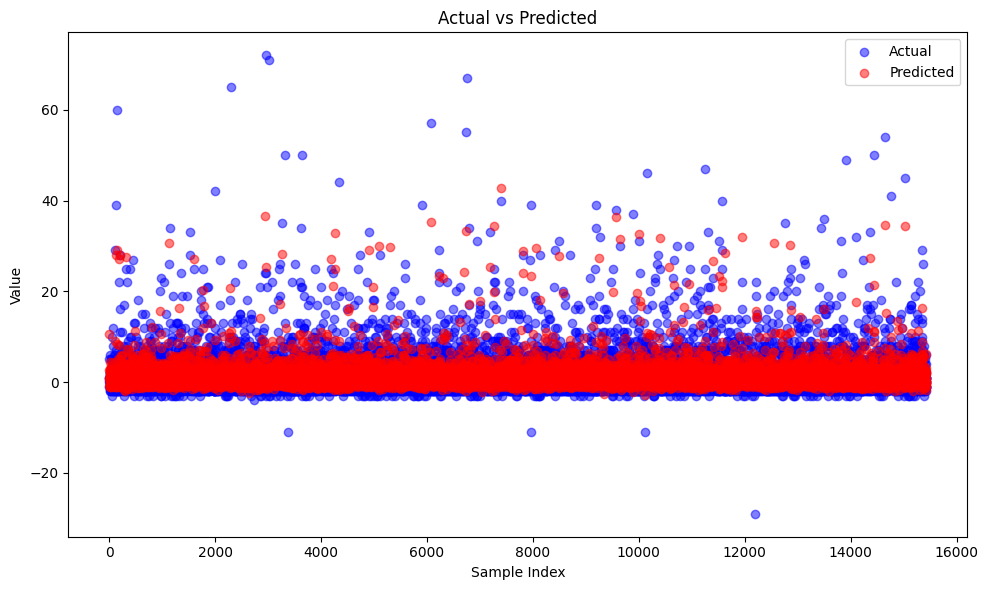

In [45]:
# Visualization
# 1. Actual vs Predicted Scatter Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', alpha=0.5, label='Actual')
plt.scatter(range(len(y_pred)), y_pred, color='red', alpha=0.5, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

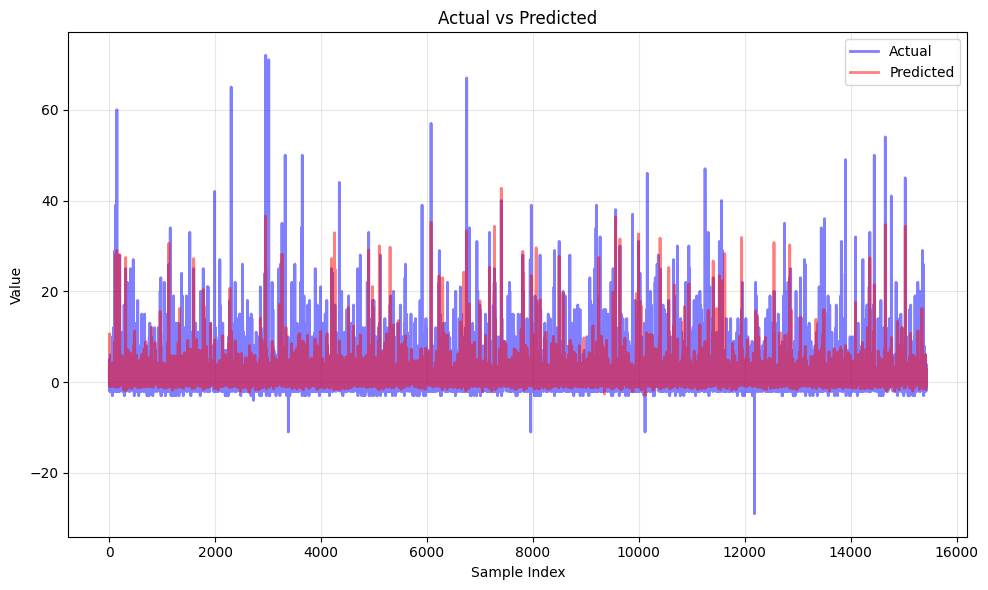

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plotting actual values
plt.plot(range(len(y_test)), y_test, color='blue', alpha=0.5, label='Actual', linewidth=2)

# Plotting predicted values
plt.plot(range(len(y_pred)), y_pred, color='red', alpha=0.5, label='Predicted', linewidth=2)

plt.title('Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)  # Optional: Adding grid for better readability
plt.tight_layout()
plt.show()

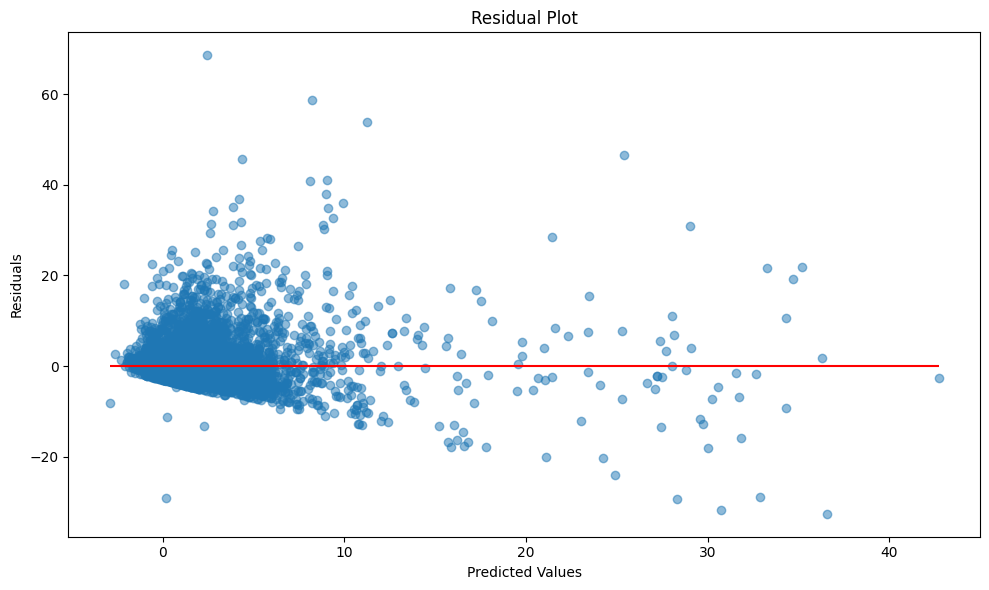

In [47]:
# 2. Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

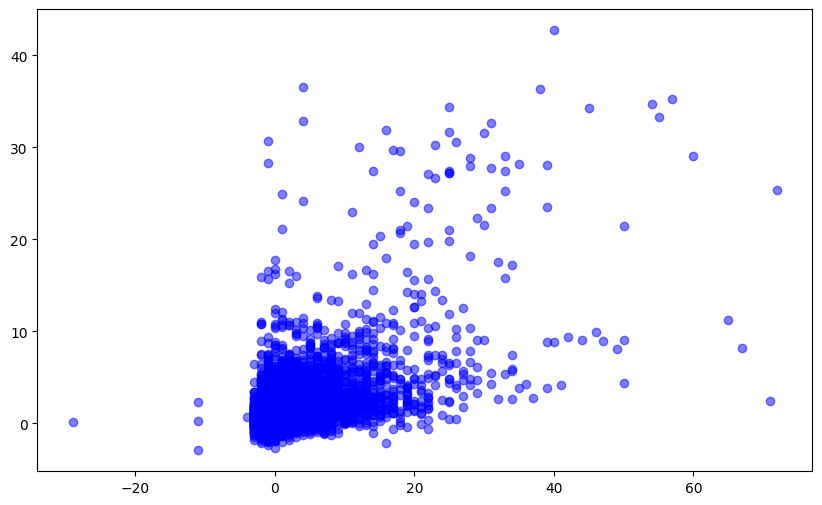

In [48]:
# 3. R² Plot: Actual vs Predicted
from sklearn.metrics import r2_score

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Create the plot
plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)

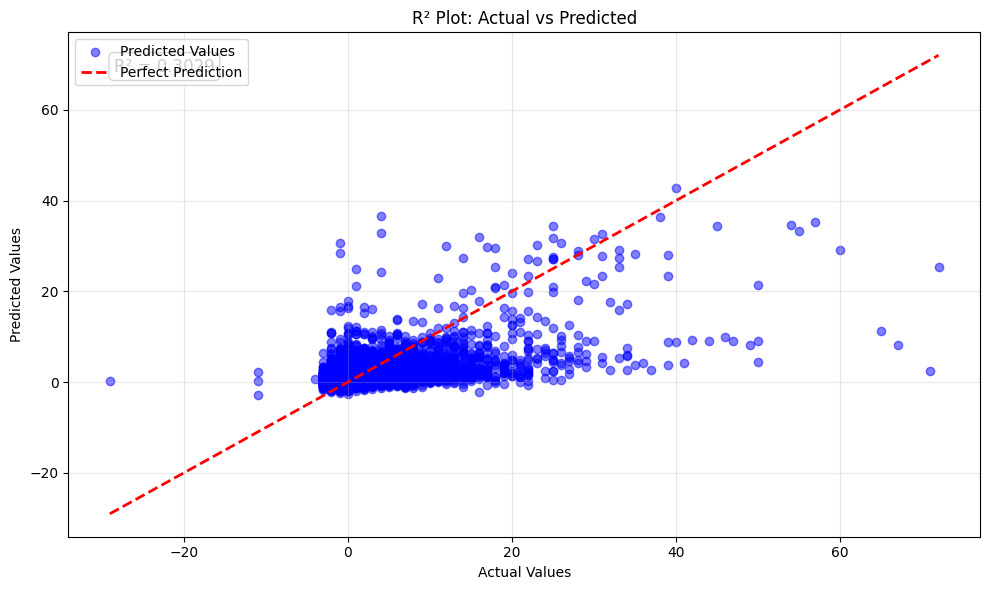

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Create the plot
plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Predicted Values')

# Perfect prediction line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Perfect Prediction')

# Customize the plot
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('R² Plot: Actual vs Predicted')

# Add R-squared value to the plot
plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=plt.gca().transAxes,
         verticalalignment='top', fontsize=12,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


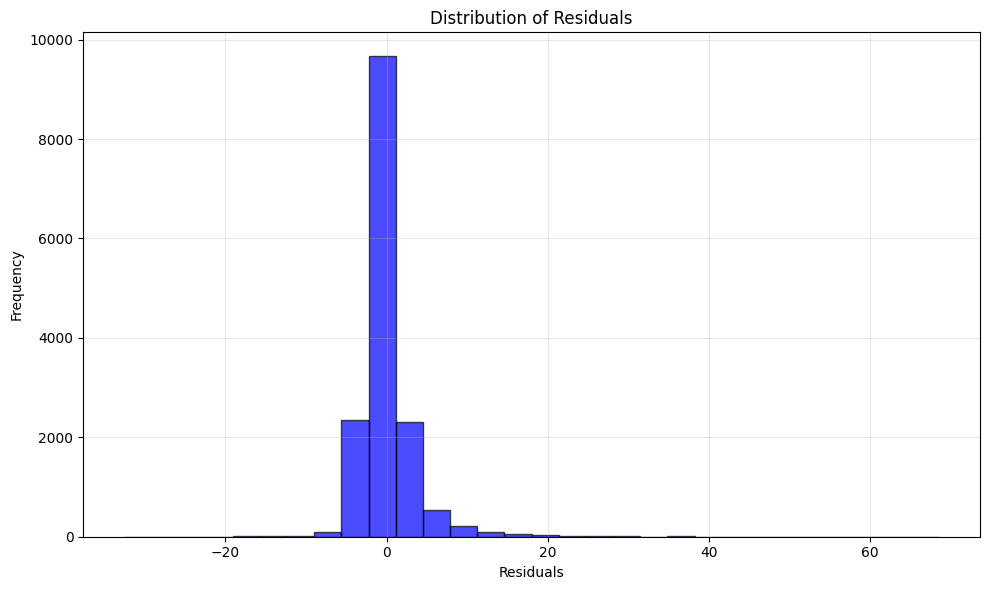

In [50]:
# Distribution of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

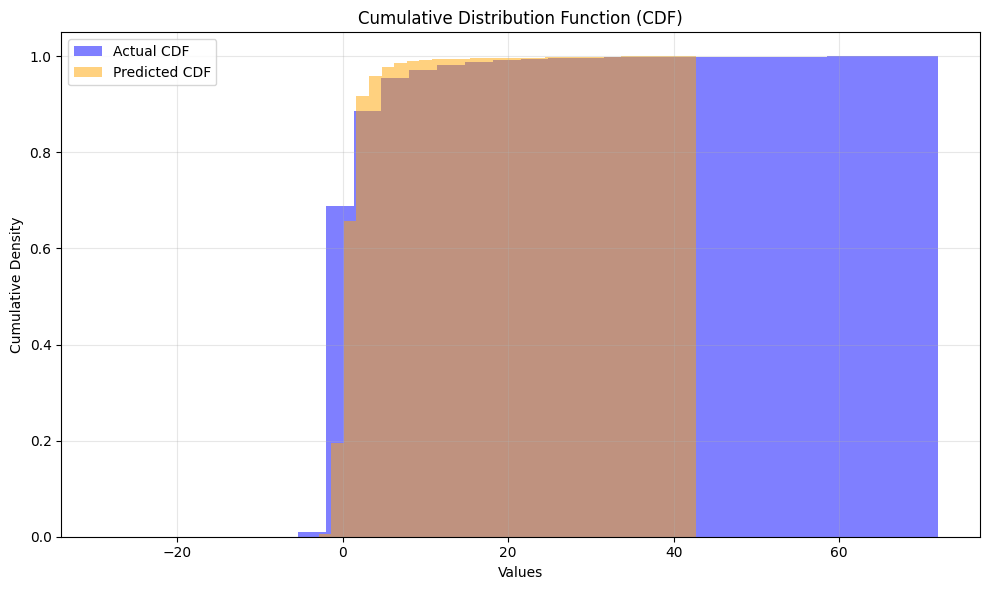

In [51]:
# CDF of Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=30, density=True, cumulative=True, color='blue', alpha=0.5, label='Actual CDF')
plt.hist(y_pred, bins=30, density=True, cumulative=True, color='orange', alpha=0.5, label='Predicted CDF')

plt.xlabel('Values')
plt.ylabel('Cumulative Density')
plt.title('Cumulative Distribution Function (CDF)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()